# Narcos

The very mention of Latin America often evokes violent images from the Netflix series Narcos of Pablo Escobar's bloody drug empire in Colombia. This project takes a look at the data, including violent crime, terror risk and gender violence, to see which countries in Latin America are the most dangerous today.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

path = os.getcwd()

## Import data

### Functions

In [2]:
# takes a wide dataframe and returns a long one with 
# the most recent year in which there was no NA value. 
def make_df_long(df, col_name, switch):
    # creates a years list with the most recent first
    data_years = df.iloc[:, 1:].iloc[:, ::-1].columns

    # iterates through each row and year untill a 
    # non-na value is found. 
    year = []
    value = []
    for row_x in range(len(df)):
        for year_x in data_years:
            datum = df.loc[row_x, year_x]
            if not np.isnan(datum):
                year.append(year_x)
                value.append(datum)
                break
            # if no non-na value is found, nas are appended
            else:
                if year_x == data_years[len(data_years)-1]:
                    year.append(np.nan)
                    value.append(np.nan)

    # creates a long dataframe with country, most recent non-na year and 
    # non-na values as columns. 
    df = pd.DataFrame({'country': df['country'], 
                       'year': year,
                       col_name: value})

    # changes positive to negative values if switch equals true
    if switch == True:
        df[col_name] = df[col_name].apply(lambda x: -x)

    return df


# imports world bank data in wide format
def import_WB_wide_data(df, col_name, switch=False):
    # read-in world bank data
    data = pd.read_csv(path + '\\' + df + '.csv')

    # define the number of columns
    col_len = len(data.columns)
    
    # define last 7 years
    last_7_years = range((col_len-7), col_len)
    
    # trim the data to country names and the last 7 years
    df = pd.concat([data.loc[:, 'Country Name'], data.iloc[:,last_7_years]], axis=1)
    
    # renames the country column for simplicity
    df.rename(columns={'Country Name': 'country',
                       'value': col_name}, inplace=True) 

    # returns a long dataframe with the most 
    return make_df_long(df, col_name, switch)


# imports world bank data in long format
def import_WB_long_data(df, col_name):
    # read-in world bank data
    data = pd.read_csv(path + '\\' + df + '.csv')

    # trim the data to country names and modeled 2018 data
    df = data.loc[data['Disaggregation']=='female, 15-49, Modeled', ['Country Name', 'Year', 'Value']]

    # returns a dataframe with a renamed country column for simplicity
    return df.rename(columns={'Country Name': 'country',
                              'Year': 'year',
                              'Value': col_name}) 

### Intentional Homicides Data

In [3]:
# reads in the data
IH_df = import_WB_wide_data(df='intentional_homocides', col_name='violent_crime')

# prints the first 6 rows
IH_df.head(6)

,country,year,violent_crime
0,Aruba,NaN,NaN
1,Africa Eastern and Southern,NaN,NaN
2,Afghanistan,2021,4.022498
3,Africa Western and Central,NaN,NaN
4,Angola,2016,4.102248
5,Albania,2021,2.311969


### Terror Risk Data

In [4]:
# reads in the data
PS_df = import_WB_wide_data(df='political_stability', col_name='terror_risk', switch=True)

# prints the first 6 rows
PS_df.head(6)

,country,year,terror_risk
0,Aruba,2022,-97.641510
1,Africa Eastern and Southern,NaN,NaN
2,Afghanistan,2022,-0.471698
3,Africa Western and Central,NaN,NaN
4,Angola,2022,-22.641510
5,Albania,2022,-50.471699


### Sexual Violence Data

In [5]:
# reads in the data
SV_df = import_WB_long_data(df='sexual_violence_last_12_months', col_name='sexual_violence')

# shows the data
SV_df.head(6)

,country,year,sexual_violence
0,East Asia & Pacific,2018,7.928985
1,Europe & Central Asia,2018,6.317913
2,High income,2018,5.601072
3,Latin America & Caribbean,2018,8.306678
4,Low income,2018,22.482199
5,Lower middle income,2018,16.864853


## Create a Final Dataframe

### Functions

In [6]:
# returns the country name of a given dataframe based on a string match
def get_country_name(df_name, data, string, col_name='country'):
    result = data.loc[[string in x for x in data[col_name]], col_name].values
    # prints a warning of the string matches more than one country name
    if len(result)>1:
        print('WARNING! Potentially 2 countries with same name!!!!' + ' --- ' + result)
        
    # in most cases returns the country name result
    elif len(result)<1:
        raise ValueError(string + ' not in ' + df_name)

    # returns the name in the dataframe
    return result[0]


# changes a country name in a given dataframe to make it uniform
def change_country_name(data, name, country, col_name='country'):
    data.loc[data[col_name]==name, col_name] = country


# standardizes country names for a given dataframe
def standardize_df_country_names(df, col_name='country'):
    for country in countries:
        name = get_country_name(df, eval(df), country)
        if name != country:
            change_country_name(eval(df), name, country)

### Standardize country names

In [7]:
# a list of relevant countries
countries = ['Colombia', 'Brazil', 'Peru', 'Argentina', 'Venezuela', 'Chile', 'Ecuador', 'Bolivia', 'Uruguay', 'Paraguay', 'Guyana', 'Suriname', 
             'Trinidad and Tobago', 'Panama', 'Guatemala', 'El Salvador', 'Belize', 'Nicaragua', 'Honduras', 'Costa Rica', 'Dominican Republic',
             'Cuba', 'Jamaica', 'Haiti', 'Mexico']

# sorts the countries by country name
countries.sort()

# a list of dataframes
dfs = ['IH_df', 'PS_df', 'SV_df']

# loops through each dataframe and stores relevant values in the dataframes object
for df in dfs:
    country = standardize_df_country_names(df)

### Create a combined dataframe

In [8]:
# creates a pandas dataframe with a countries column
combined_df = pd.DataFrame({'country': countries})

# adds in the other columns for each datatype
for df in dfs:
    df = eval(df)
    data = df[df['country'].isin(countries)].sort_values('country').iloc[:,2].reset_index(drop=True)
    name = data.name
    combined_df[name] = data

# shows the data
combined_df.head(6)

,country,violent_crime,terror_risk,sexual_violence
0,Argentina,4.622679,-46.698112,5.0
1,Belize,31.247578,-59.433964,8.0
2,Bolivia,3.493530,-36.320755,18.0
3,Brazil,22.384065,-33.962265,6.0
4,Chile,3.632039,-51.415092,6.0
5,Colombia,27.484365,-23.113207,12.0


### View NAs

In [9]:
# determuine how many NAs are in each data source
new_df = combined_df.iloc[:,1:len(combined_df.columns)]
cols = new_df.columns

print()
for i, col in enumerate(cols):
    print(str(col) + ' --- NAs --- ' + str(new_df.iloc[:,i].isnull().sum()))


violent_crime --- NAs --- 0
terror_risk --- NAs --- 0
sexual_violence --- NAs --- 0


### Normalize values

In [10]:
# normalizes values by scalling to range, multiplying the result by 5 and then rounding that to the nearest 2 digits.
# this gives us a relative 0-5 score for each column. 
def normalize_values(df, column):
    max = df[column].max()
    min = df[column].min()
    return [round(((x - min) / (max - min)) * 5, 2) for x in df[column]]

# creates a combined df with normalized values
columns = combined_df.columns
for column in columns[1:]:
    combined_df[column] = normalize_values(combined_df, column)

# shows the dataframe
combined_df.head(6)

,country,violent_crime,terror_risk,sexual_violence
0,Argentina,0.12,2.67,0.36
1,Belize,2.85,1.85,1.43
2,Bolivia,0.00,3.33,5.00
3,Brazil,1.94,3.48,0.71
4,Chile,0.01,2.36,0.71
5,Colombia,2.47,4.18,2.86


## Visualize data

### Functions

In [11]:
# returns  barplots of the data for a selected range of countries
def get_viz(df, title):

    # defines the colors we want to use
    colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:cyan', 'tab:purple', 'tab:pink', 'tab:brown', 'black']
    
    # creates a list of ylabels
    ylabels = ['Intentional Homicides (0-5)', 'Political Stability (0-5)', 'Sexual Violence Against Women (0-5)']

    # creates an x object of country names
    x = df['country']

    # stores the column names as Ys
    Ys = df.columns[1:]
    
    # creates a subplots objects and flattenes it for easy plotting
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    #ax = ax.flatten()
    
    # loops through each plot
    for i, y in enumerate(Ys):
        ax[i].bar(x, df[y], color=colors);
        ax[i].set_title(' '.join(y.split('_')).title());
        ax[i].set_ylabel(ylabels[i]);
        ax[i].set_ylim(0,5);
        ax[i].set_xticks(x);
        ax[i].set_xticklabels(x, rotation=45);
        ax[i].axhline(y=2.5, color='red', linestyle='--', label='Latin America Average')
        ax[i].legend()
    
    # adjust layout for better spacing
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    
    # add overall title
    fig.suptitle(title, fontsize=20, y=1.1)
    
    # show the plots
    plt.show()

# gets a dataframe based on the countries given and creates the visualization
def get_df_viz(countries, title):
    # creates a new dataframe
    df = combined_df.loc[[True if x in countries else False for x in combined_df['country']]].reset_index(drop=True)

    # get visualization
    get_viz(df, title)

### South America

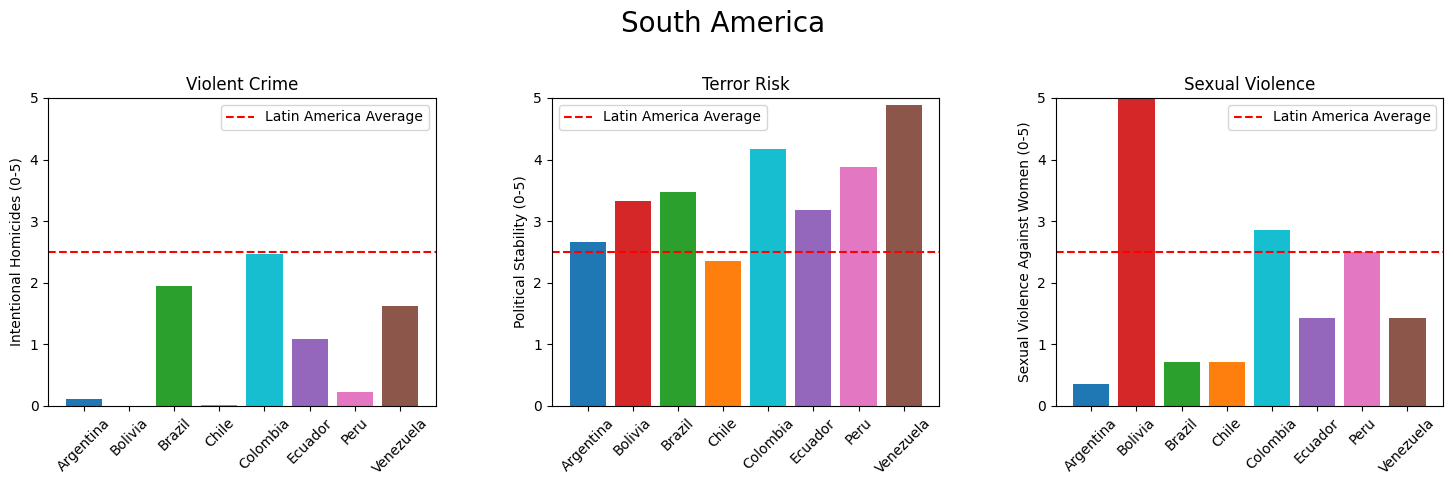

In [12]:
# defines the countries we want to look at
SA_countries = ['Colombia', 'Brazil', 'Peru', 'Argentina', 'Venezuela', 'Chile', 'Ecuador', 'Bolivia']

# creates the visualization
get_df_viz(SA_countries, 'South America')

### Central & North America

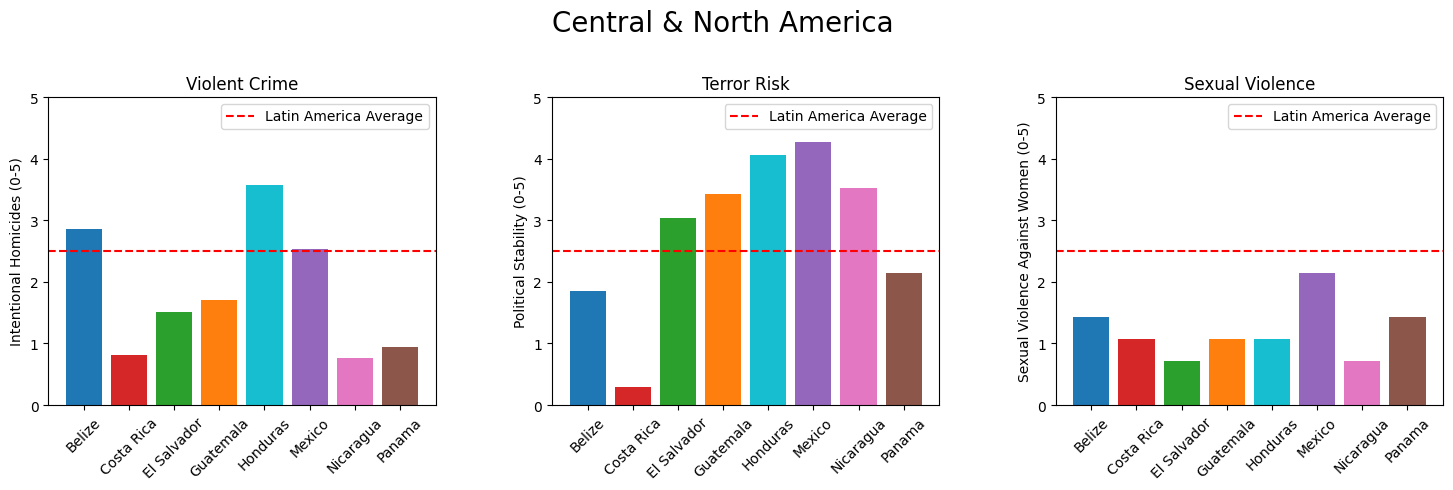

In [13]:
# defines the countries we want to look at
CA_countries = ['Panama', 'Guatemala', 'El Salvador', 'Belize', 'Nicaragua', 'Honduras', 'Costa Rica', 'Mexico']

# creates the visualization
get_df_viz(CA_countries, 'Central & North America')

### The Caribbean

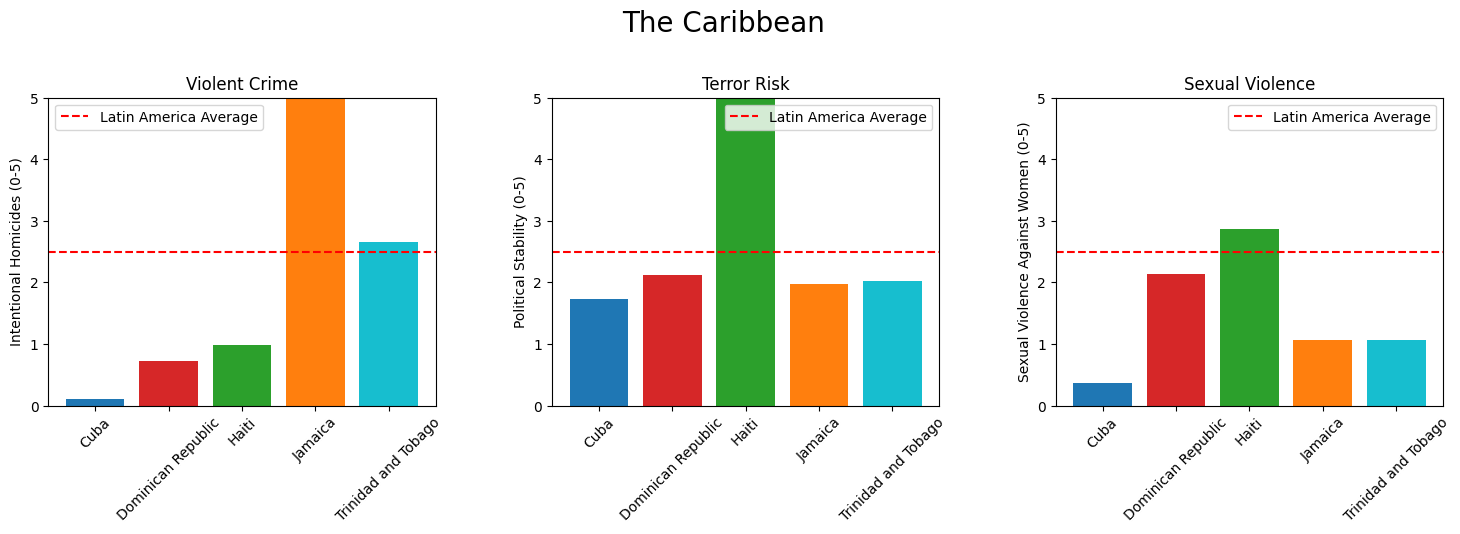

In [14]:
# defines the countries we want to look at
C_countries = ['Dominican Republic', 'Cuba', 'Jamaica', 'Haiti', 'Trinidad and Tobago']

# creates the visualization
get_df_viz(C_countries, 'The Caribbean')